# CS5670 Project 5B

In this problem set, you will train your own diffusion model on the MNIST dataset. You’ll build and train UNet-based diffusion models, gaining hands-on experience with both unconditional and class-conditioned generation.

Please refer to the [Project 5B instructions page](https://www.cs.cornell.edu/courses/cs5670/2025sp/projects/5_project/partB.html) for detailed descriptions of each task and submission instructions.

## Setup environment

In [ ]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [ ]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import dataclasses
import torch
import numpy as np
import random
import torch.optim as optim
import mediapy as media
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn

checkpoint_dir='/content/drive/MyDrive/cs5670'
os.makedirs(checkpoint_dir,exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Training a Single-step Denoising UNet


## Deliverables
In summary, your deliverables should include the following for this problem:

1.   A visualization of different noising process over $\sigma = [0.0, 0.25, 0.5, 0.75, 1.0]$ (see Figure 3 on the [instruction page](https://www.cs.cornell.edu/courses/cs5670/2025sp/projects/5_project/partB.html)).
2.   A training loss curve plot every few iterations during the whole training process (see Figure 4).
3.   Sample results on the test set after the first and the 5-th epoch (staff solution takes ~7 minutes for 5 epochs on a Colab T4 GPU). (see Figures 5 and 6)
4.   Sample results on the test set with out-of-distribution noise levels after the model is trained. Keep the same image and vary $\sigma = [0.0, 0.25, 0.5, 0.75, 1.0, 1.0]$ (see Figure 7).

### Hint

Since training can take a while, we strongly recommend that you checkpoint your model every epoch onto your personal Google Drive. This is because Colab notebooks aren't persistent such that if you are idle for a while, you will lose connection and your training progress. This consists of:

- Google Drive mounting.
- Epoch-wise model & optimizer checkpointing.
- Model & optimizer resuming from checkpoints.

## 1.1 Implementing the UNet

### Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
      self.bn=nn.BatchNorm2d(out_channels)
      self.activation=nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x=self.conv(x)
      x=self.bn(x)
      x=self.activation(x)
      return x

class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv=nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1)
      self.bn=nn.BatchNorm2d(out_channels)
      self.activation=nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x=self.conv(x)
      x=self.bn(x)
      x=self.activation(x)
      return x

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
      super().__init__()
      self.conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1)
      self.bn=nn.BatchNorm2d(out_channels)
      self.activation=nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x=self.conv(x)
      x=self.bn(x)
      x=self.activation(x)
      return x


class Flatten(nn.Module):
    def __init__(self):
      super().__init__()
      self.pool=nn.AvgPool2d(kernel_size=7)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.pool(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv=nn.ConvTranspose2d(in_channels,in_channels,kernel_size=7,stride=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1=Conv(in_channels,out_channels)
        self.conv2=Conv(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x=self.conv1(x)
        x=self.conv2(x)
        return x

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down=DownConv(in_channels,out_channels)
        self.conv_block=ConvBlock(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x=self.down(x)
        x=self.conv_block(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up=UpConv(in_channels,out_channels)
        self.conv_block=ConvBlock(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x=self.up(x)
        x=self.conv_block(x)
        return x

### Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels=in_channels
        self.num_hiddens=num_hiddens
        self.conv_in=ConvBlock(in_channels,num_hiddens)
        self.down1=DownBlock(num_hiddens,num_hiddens//2)
        self.down2=DownBlock(num_hiddens//2,num_hiddens//4)
        self.flatten=Flatten()
        self.unflatten=Unflatten(num_hiddens//4)
        self.up1=UpBlock(num_hiddens//2,num_hiddens//2)
        self.up2=UpBlock(num_hiddens,num_hiddens)
        self.final_conv=ConvBlock(2*num_hiddens,num_hiddens)
        self.conv_out=nn.Conv2d(num_hiddens,in_channels,kernel_size=3,stride=1,padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:]==(28,28)
        x1=self.conv_in(x)
        x2=self.down1(x1)
        x3=self.down2(x2)
        x_bottleneck=self.flatten(x3)
        x4=self.unflatten(x_bottleneck)
        x4=torch.cat([x4,x3],dim=1)
        x5=self.up1(x4)
        x5=torch.cat([x5,x2],dim=1)
        x6=self.up2(x5)
        x6=torch.cat([x6,x1],dim=1)
        x7=self.final_conv(x6)
        out=self.conv_out(x7)
        return out

## 1.2 Using the UNet to Train a Denoiser
In this part, you will train your UNet to perform single-step denoising on MNIST images. You will define your configuration, prepare data, implement training, and visualize results.

### 1.2.1 Training

In [ ]:
# @title Configuration and setup
# Define your configuration using dataclass
# Include: device (e.g., "cuda"), data_dir, batch_size, num_epochs, lr, num_hiddens
# === CODE TODO BEGIN ===

@dataclasses.dataclass
class SingleStepConfig(object):
    device: str = 'cuda'  # TODO
    data_dir: str = "./data"  # TODO
    batch_size: int = 256  # TODO
    num_epochs: int = 5  # TODO
    lr: float = 1e-4  # TODO
    num_hiddens: int = 128  # TODO
    noise_level: float = 0.5

# === CODE TODO END ===

# Set random seeds for reproducibility using random, numpy, and torch
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(0)
cfg = SingleStepConfig()

In [ ]:
#@title Load dataset and initialize model/optimizer
# === CODE TODO BEGIN ===
# Load the MNIST dataset (from torchvision.datasets)
# Prepare DataLoader with shuffling for training and no shuffling for testing
train_dataset =MNIST(root=cfg.data_dir,train=True,download=True,transform=ToTensor())  # TODO
test_dataset =MNIST(root=cfg.data_dir,train=False,download=True,transform=ToTensor())  # TODO

train_loader =DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)  # TODO
test_loader =DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)  # TODO

# Instantiate your UnconditionalUNet model (from 1.1) and move it to cfg.device
model =UnconditionalUNet(in_channels=1,num_hiddens=cfg.num_hiddens).to(cfg.device)  # TODO: Replace with model definition
model = model.to(cfg.device)
for param in model.parameters():
    param.data = param.data.to(cfg.device)
# Define the Adam optimizer
optimizer =optim.Adam(model.parameters(),lr=cfg.lr)  # TODO: Replace with optimizer definition
train_losses = []

# === CODE TODO END ===

In [ ]:
# @title Deliverable 1-1
# A visualization of different noising process over sigma = [0.0, 0.25, 0.5, 0.75, 1.0].
# Hint: you may need to reshape or arrange the image tensors,
# and use media.show_images to display results

# === CODE TODO BEGIN ===

def noise_adder(images,noise_level):
 noise=torch.randn_like(images)*noise_level
 noisy_images=images+noise
 return noisy_images,noise

def noise_visual(images,sigmas=[0.0,0.2,0.4,0.5,0.6,0.8,1.0]):
 n_samples=min(5,images.shape[0])
 images=images[:n_samples]
 all_images=[]
 for i in range(n_samples):
  row_images=[]
  for sigma in sigmas:
   if sigma==0:
    noisy_img=images[i]
   else:
    noise=torch.randn_like(images[i])*sigma
    noisy_img=images[i]+noise
   noisy_img=torch.clamp(noisy_img,0,1)
   img_np=noisy_img.squeeze().cpu().numpy()
   row_images.append(img_np)
  all_images.extend(row_images)
 titles=[f'σ={sigma}' for sigma in sigmas]*n_samples
 media.show_images(all_images,columns=len(sigmas),titles=titles)

for images,_ in test_loader:
 noise_visual(images)
 break

# === CODE TODO END ===

σ=0.0,σ=0.2,σ=0.4,σ=0.5,σ=0.6,σ=0.8,σ=1.0
σ=0.0,σ=0.2,σ=0.4,σ=0.5,σ=0.6,σ=0.8,σ=1.0
σ=0.0,σ=0.2,σ=0.4,σ=0.5,σ=0.6,σ=0.8,σ=1.0
σ=0.0,σ=0.2,σ=0.4,σ=0.5,σ=0.6,σ=0.8,σ=1.0
σ=0.0,σ=0.2,σ=0.4,σ=0.5,σ=0.6,σ=0.8,σ=1.0


In [ ]:
#@title Training loop
# Assumes you have:
# - model: your UNet denoiser
# - optimizer: Adam optimizer
# - train_loader: batches of MNIST images
# - device: "cuda" or "cpu"
# - loss_fn: a loss function
# Impltement the training loop to train your model for several epochs
# Remember to use your configuration, e.g. cfg.batch_size and cfg.device
# === CODE TODO BEGIN ===


criterion=nn.MSELoss()
all_losses=[]
model.to(cfg.device)
for epoch in range(cfg.num_epochs):
 model.train()
 epoch_loss=0.0
 for batch_idx,(images,_) in enumerate(train_loader):
  images=images.to(cfg.device)
  noise=torch.randn_like(images)*cfg.noise_level
  noisy_images=images+noise
  optimizer.zero_grad()
  outputs=model(noisy_images)
  loss=criterion(outputs,images)
  loss.backward()
  optimizer.step()
  batch_loss=loss.item()
  epoch_loss+=batch_loss
  all_losses.append(batch_loss)
 avg_loss=epoch_loss/len(train_loader)
 print(f'epoch [{epoch+1}/{cfg.num_epochs}], loss: {avg_loss:.6f}')
 checkpoint_path=os.path.join(checkpoint_dir,f'model_epoch_{epoch+1}.pt')
 torch.save({
  'epoch':epoch+1,
  'model_state_dict':model.state_dict(),
  'optimizer_state_dict':optimizer.state_dict(),
  'loss':avg_loss,
 },checkpoint_path)

def load_checkpoint(checkpoint_path):
 checkpoint=torch.load(checkpoint_path)
 model.load_state_dict(checkpoint['model_state_dict'])
 model.to(cfg.device)
 optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
 epoch=checkpoint['epoch']
 return epoch


# === CODE TODO END ===

epoch [1/5], loss: 0.023819
epoch [2/5], loss: 0.011844
epoch [3/5], loss: 0.010571
epoch [4/5], loss: 0.009719
epoch [5/5], loss: 0.009168


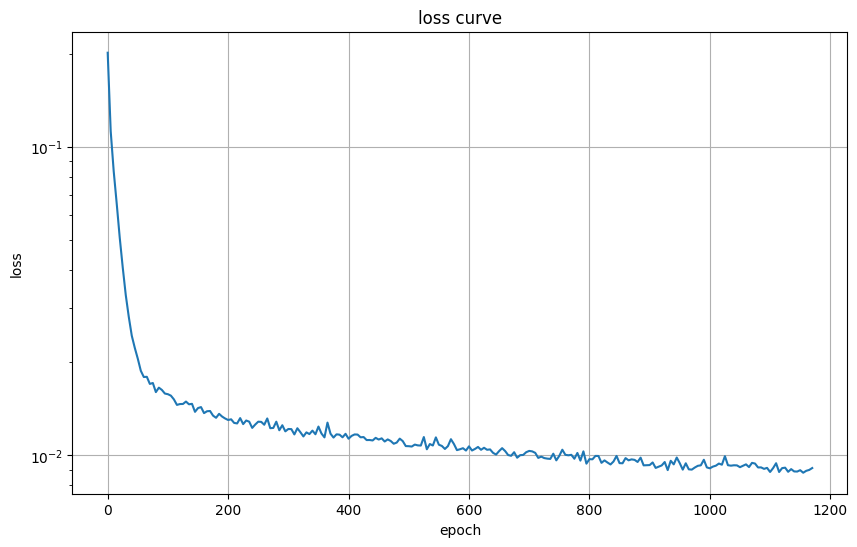

In [ ]:
# @title Deliverable 1-2
# A training loss curve plot every few iterations during the whole training process.
# === CODE TODO BEGIN ===

interval = 5
x_values = range(0, len(all_losses), interval)
y_values = [all_losses[i] for i in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# === CODE TODO END ===

In [ ]:
# @title Deliverable 1-3
# Sample results on the test set after the first and the 5-th epoch
# Hint: You can either visualize results immediately during training (recommended for easier comparison),
#  or Store outputs and visualize later after training.
# === CODE TODO BEGIN ===


def denoising(model,test_loader,epoch,device,noise_level=0.5,num_samples=3):
    model.eval()
    for images,_ in test_loader:
        test_images=images[:num_samples].to(device)
        break
    with torch.no_grad():
        noise=torch.randn_like(test_images)*noise_level
        noisy_images=test_images+noise
        denoised_images=model(noisy_images)
        originals=test_images.cpu().numpy()
        noisies=noisy_images.cpu().numpy()
        denoised=denoised_images.cpu().numpy()
        for i in range(num_samples):
            imgs=[
                originals[i].squeeze(),
                noisies[i].squeeze(),
                denoised[i].squeeze()
            ]
            media.show_images(imgs,titles=['original','noisy',f'denoised (epoch {epoch})'],columns=3)

checkpoint_path_epoch1=os.path.join(checkpoint_dir,'model_epoch_1.pt')
checkpoint_epoch1=torch.load(checkpoint_path_epoch1)
model.load_state_dict(checkpoint_epoch1['model_state_dict'])
denoising(model,test_loader,1,cfg.device,cfg.noise_level)

checkpoint_path_epoch5=os.path.join(checkpoint_dir,'model_epoch_5.pt')
checkpoint_epoch5=torch.load(checkpoint_path_epoch5)
model.load_state_dict(checkpoint_epoch5['model_state_dict'])
denoising(model,test_loader,5,cfg.device,cfg.noise_level)
# === CODE TODO END ===

original,noisy,denoised (epoch 1)


original,noisy,denoised (epoch 1)


original,noisy,denoised (epoch 1)


original,noisy,denoised (epoch 5)


original,noisy,denoised (epoch 5)


original,noisy,denoised (epoch 5)


### 1.2.2 Out-of-Distribution Testing

In [ ]:
# @title Deliverable 1-4
# Sample results on the test set with out-of-distribution noise levels after the model is trained.
# Keep the same image and vary \sigma = [0.0, 0.25, 0.5, 0.75, 1.0, 1.0].
# === CODE TODO BEGIN ===

def visualize(model,test_loader,device,noise_levels=[0.0,0.25,0.5,0.75,1.0]):
    model.eval()
    for images,_ in test_loader:
        test_image=images[0:1].to(device)
        break
    all_denoised=[]
    with torch.no_grad():
        for noise_level in noise_levels:
            noise=torch.randn_like(test_image)*noise_level
            noisy_image=test_image+noise
            denoised_image=model(noisy_image).cpu()
            img=denoised_image[0].squeeze().numpy()
            all_denoised.append(img)
    media.show_images(all_denoised,titles=[f"σ={s}" for s in noise_levels],columns=len(noise_levels))
checkpoint_path=os.path.join(checkpoint_dir,'model_epoch_5.pt')
checkpoint=torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
visualize(model,test_loader,cfg.device)

# === CODE TODO END ===

σ=0.0,σ=0.25,σ=0.5,σ=0.75,σ=1.0


# Part 2: Training a Diffusion Model

## Deliverables for Time-conditioned UNet
- A training loss curve plot for the time-conditioned UNet over the whole training process (figure 10).
- Sampling results for the time-conditioned UNet for 5 and 20 epochs.
Note: providing a gif is optional.

## 2.1 Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block=nn.Sequential(
            nn.Linear(in_channels,out_channels),
            nn.GELU(),
            nn.Linear(out_channels,out_channels)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

import torch.nn.functional as F

class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels=in_channels
        self.num_classes=num_classes
        self.num_hiddens=num_hiddens
        self.conv_in=ConvBlock(in_channels,num_hiddens)
        self.down1=DownBlock(num_hiddens,num_hiddens//2)
        self.down2=DownBlock(num_hiddens//2,num_hiddens//4)
        self.flatten=Flatten()
        self.unflatten=Unflatten(num_hiddens//4)
        self.fc1_t=FCBlock(1,num_hiddens//4)
        self.fc2_t=FCBlock(1,num_hiddens//2)
        self.up1=UpBlock(num_hiddens//2,num_hiddens//2)
        self.up2=UpBlock(num_hiddens,num_hiddens)
        self.final_conv=ConvBlock(2*num_hiddens,num_hiddens)
        self.conv_out=nn.Conv2d(num_hiddens,in_channels,kernel_size=3,stride=1,padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        t=t.unsqueeze(1)
        x1=self.conv_in(x)
        x2=self.down1(x1)
        x3=self.down2(x2)
        x_bottleneck=self.flatten(x3)
        x4=self.unflatten(x_bottleneck)
        t1=self.fc1_t(t)
        t2=self.fc2_t(t)
        x4=x4+t1.unsqueeze(-1).unsqueeze(-1)
        x4=torch.cat([x4,x3],dim=1)
        x5=self.up1(x4)
        x5=x5+t2.unsqueeze(-1).unsqueeze(-1)
        x5=torch.cat([x5,x2],dim=1)
        x6=self.up2(x5)
        x6=torch.cat([x6,x1],dim=1)
        x7=self.final_conv(x6)
        out=self.conv_out(x7)
        return out

## 2.2 Training the UNet and 2.3 Sampling from the UNet

### Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas=torch.linspace(beta1,beta2,num_ts)
    alphas=1.0-betas
    alpha_bars=torch.cumprod(alphas,dim=0)
    return {
        'betas':betas,
        'alphas':alphas,
        'alpha_bars':alpha_bars
    }

In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    N=x_0.size(0)
    device=x_0.device
    t=torch.randint(0,num_ts,(N,),device=device)
    alpha_bars=ddpm_schedule['alpha_bars'].to(device)
    sqrt_alpha_bars=torch.sqrt(alpha_bars[t]).view(-1,1,1,1)
    sqrt_one_minus_alpha_bars=torch.sqrt(1.0-alpha_bars[t]).view(-1,1,1,1)
    eps=torch.randn_like(x_0)
    x_t=sqrt_alpha_bars*x_0+sqrt_one_minus_alpha_bars*eps
    eps_pred=unet(x_t,t/num_ts)
    loss=F.mse_loss(eps_pred,eps)
    return loss


In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    torch.manual_seed(seed)
    device=next(unet.parameters()).device
    H,W=img_wh
    N,C=1,1
    betas=ddpm_schedule['betas'].to(device)
    alphas=ddpm_schedule['alphas'].to(device)
    alpha_bars=ddpm_schedule['alpha_bars'].to(device)
    x=torch.randn(N,C,H,W,device=device)
    for t_inv in reversed(range(num_ts)):
        t=torch.full((N,),t_inv,device=device)
        alpha=alphas[t_inv]
        alpha_bar=alpha_bars[t_inv]
        beta=betas[t_inv]
        z=torch.randn_like(x) if t_inv>0 else torch.zeros_like(x)
        eps_pred=unet(x,t/num_ts)
        coef1=1/torch.sqrt(alpha)
        coef2=(1-alpha)/torch.sqrt(1-alpha_bar)
        mean=coef1*(x-beta*eps_pred/torch.sqrt(1-alpha_bar))
        x=mean+torch.sqrt(beta)*z
    return x

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

### Training

In [ ]:
# @title Configuration and setup
# Define your configuration class for DDPM
# Include: device, data_dir, work_dir, num_hiddens, num_ts, p_uncond, betas, num_epochs, batch_size, lr, lr_decay

# === CODE TODO BEGIN ===
@dataclasses.dataclass
class DDPMConfig(object):
    device: str = "cuda"   # TODO
    data_dir: str = "./data"  # TODO
    work_dir: str = "./checkpoints"  # TODO
    num_hiddens: int = 256  # TODO
    num_ts: int = 300  # TODO  # number of diffusion steps
    p_uncond: float = 0.1  # TODO  # classifier-free guidance dropout probability
    betas: tuple[float, float] = (1e-4, 0.02)  # TODO  # linear noise schedule
    num_epochs: int = 20  # TODO
    batch_size: int = 128  # TODO
    lr: float = 1e-3  # TODO
    lr_decay: float = 0.1**(1.0/20)  # TODO
# === CODE TODO END ===

# Set random seed
seed_everything(0)
# Create config instance
cfg = DDPMConfig()

In [ ]:
#@title Load dataset and initialize model/optimizer/schedule
# === CODE TODO BEGIN ===
# Load the MNIST dataset (from torchvision.datasets)
# Prepare DataLoader with shuffling for training and no shuffling for testing
train_dataset =MNIST(root=cfg.data_dir,train=True,download=True,transform=ToTensor())
test_dataset =MNIST(root=cfg.data_dir,train=False,download=True,transform=ToTensor())

train_loader =DataLoader(train_dataset,batch_size=cfg.batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_loader =DataLoader(test_dataset,batch_size=cfg.batch_size,shuffle=False,num_workers=2,pin_memory=True)

# Create the beta schedule for DDPM (use ddpm_schedule helper)
schedule = ddpm_schedule(cfg.betas[0],cfg.betas[1],cfg.num_ts)  # TODO

# Instantiate your TimeConditionalUNet model (from 2.1) and move it to cfg.device
model = TimeConditionalUNet(
    in_channels=1,
    num_classes=10,
    num_hiddens=cfg.num_hiddens
).to(cfg.device)
  # TODO

# Create optimizer (Adam) and learning rate scheduler (ExponentialLR)
optimizer =optim.Adam(model.parameters(),lr=cfg.lr)  # TODO
scheduler =optim.lr_scheduler.ExponentialLR(optimizer,gamma=cfg.lr_decay)  # TODO
# === CODE TODO END ===

In [ ]:
#@title Training loop
# Assumes you have:
# - model: a Conditional UNet (time- and class-conditioned) on cfg.device
# - optimizer: Adam optimizer with learning rate cfg.lr
# - scheduler: ExponentialLR to decay learning rate over cfg.num_epochs
# - train_loader: batches of MNIST images and labels
# - schedule: output of ddpm_schedule
# - cfg: your DDPMConfig instance containing training parameters
# - device: "cuda" or "cpu"
# Impltement the training loop to train your model for several epochs
# === CODE TODO BEGIN ===


checkpoint_dir=os.path.join('/content/drive/MyDrive','ddpm_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

all_losses=[]
epoch_avg_losses=[]
sample_results={}

for epoch in range(cfg.num_epochs):
    print(f"epoch {epoch+1}/{cfg.num_epochs}")
    model.train()
    epoch_losses=[]

    for batch_idx, (images, _) in enumerate(train_loader):
        images=images.to(cfg.device)
        optimizer.zero_grad()
        loss=ddpm_forward(model, schedule, images, cfg.num_ts)
        loss.backward()
        optimizer.step()
        batch_loss=loss.item()
        all_losses.append(batch_loss)
        epoch_losses.append(batch_loss)

    scheduler.step()
    avg_loss=sum(epoch_losses)/len(epoch_losses)
    epoch_avg_losses.append(avg_loss)
    print(f"epoch {epoch+1} loss: {avg_loss:.6f}")

    checkpoint_path=os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    torch.save({
        'epoch':epoch+1,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'scheduler_state_dict':scheduler.state_dict(),
        'loss':avg_loss,
    }, checkpoint_path)

    if (epoch+1) in [5,20]:
        model.eval()
        with torch.no_grad():
            samples=ddpm_sample(model, schedule, (28, 28), cfg.num_ts, seed=epoch)
            sample_results[epoch+1]=samples
        print(f"samples for epoch {epoch+1}")

# === CODE TODO END ===

epoch 1/20
epoch 1 loss: 0.102407
epoch 2/20
epoch 2 loss: 0.049789
epoch 3/20
epoch 3 loss: 0.040983
epoch 4/20
epoch 4 loss: 0.037864
epoch 5/20
epoch 5 loss: 0.035519
samples for epoch 5
epoch 6/20
epoch 6 loss: 0.034551
epoch 7/20
epoch 7 loss: 0.032931
epoch 8/20
epoch 8 loss: 0.031613
epoch 9/20
epoch 9 loss: 0.031319
epoch 10/20
epoch 10 loss: 0.030800
epoch 11/20
epoch 11 loss: 0.030092
epoch 12/20
epoch 12 loss: 0.029811
epoch 13/20
epoch 13 loss: 0.029765
epoch 14/20
epoch 14 loss: 0.029137
epoch 15/20
epoch 15 loss: 0.028386
epoch 16/20
epoch 16 loss: 0.028379
epoch 17/20
epoch 17 loss: 0.028170
epoch 18/20
epoch 18 loss: 0.028040
epoch 19/20
epoch 19 loss: 0.027682
epoch 20/20
epoch 20 loss: 0.027562
samples for epoch 20


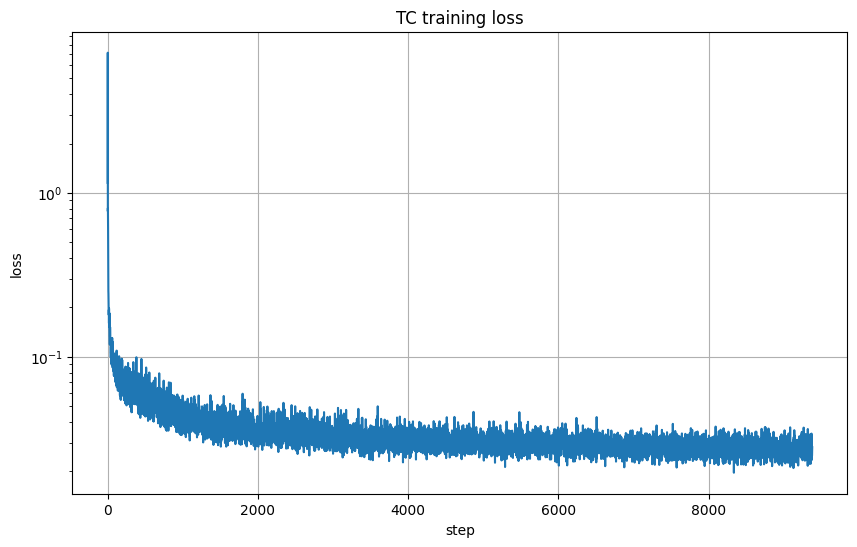

In [ ]:
# @title Deliverable 2-1
# A training loss curve plot for the time-conditioned UNet over the whole training process.
# === CODE TODO BEGIN ===

plt.figure(figsize=(10, 6))
plt.plot(all_losses)
plt.title('TC training loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# === CODE TODO END ===

In [ ]:
# @title Deliverable 2-2
# Sampling results for the time-conditioned UNet for 5 and 20 epochs. Note: providing a gif is optional.
# Hint: You can either visualize results immediately during training (recommended for easier comparison),
#  or Store outputs and visualize later after training.
# === CODE TODO BEGIN ===
# @title Deliverable 2-2
# Sampling results for the time-conditioned UNet for 5 and 20 epochs. Note: providing a gif is optional.
# === CODE TODO BEGIN ===

def samples(model, epoch, num_samples=16):
    checkpoint_path=os.path.join(checkpoint_dir,f"model_epoch_{epoch}.pt")
    checkpoint=torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()
    samples_list=[]
    with torch.no_grad():
        for i in range(num_samples):
            sample=ddpm_sample(model,schedule,(28, 28),cfg.num_ts,seed=i)
            sample_np=sample.squeeze().cpu().numpy()
            samples_list.append(sample_np)

    return samples_list


print("from epoch 5:")
model_epoch5=TimeConditionalUNet(in_channels=1,num_classes=10,num_hiddens=cfg.num_hiddens).to(cfg.device)
samples_epoch_5=samples(model_epoch5,5)
media.show_images(samples_epoch_5,columns=4)

print("from epoch 20:")
model_epoch20=TimeConditionalUNet(in_channels=1,num_classes=10,num_hiddens=cfg.num_hiddens).to(cfg.device)
samples_epoch_20=samples(model_epoch20,20)
media.show_images(samples_epoch_20,columns=4)
# === CODE TODO END ===




from epoch 5:


,,,
,,,
,,,
,,,


from epoch 20:


,,,
,,,
,,,
,,,


## Deliverables for Class-conditioned UNet
- A training loss curve plot for the class-conditioned UNet over the whole training process.
- Sampling results for the class-conditioned UNet for 5 and 20 epochs. Generate 4 instances of each digit as shown above.
Note: providing a gif is optional.

## 2.4 Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels=in_channels
        self.num_classes=num_classes
        self.num_hiddens=num_hiddens
        self.conv_in=ConvBlock(in_channels,num_hiddens)
        self.down1=DownBlock(num_hiddens,num_hiddens//2)
        self.down2=DownBlock(num_hiddens//2,num_hiddens//4)
        self.flatten=Flatten()
        self.unflatten=Unflatten(num_hiddens//4)
        self.fc1_t=FCBlock(1,num_hiddens//4)
        self.fc2_t=FCBlock(1,num_hiddens//2)
        self.fc1_c=FCBlock(num_classes,num_hiddens//4)
        self.fc2_c=FCBlock(num_classes,num_hiddens//2)
        self.up1=UpBlock(num_hiddens//2,num_hiddens//2)
        self.up2=UpBlock(num_hiddens,num_hiddens)
        self.final_conv=ConvBlock(2*num_hiddens,num_hiddens)
        self.conv_out=nn.Conv2d(num_hiddens,in_channels,kernel_size=3,stride=1,padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        t=t.unsqueeze(1)
        N=x.shape[0]
        c_one_hot=torch.zeros(N,self.num_classes,device=x.device)
        c_one_hot.scatter_(1,c.unsqueeze(1),1)
        if mask is not None:
            mask=mask.view(-1,1)
            c_one_hot=c_one_hot*mask
        x1=self.conv_in(x)
        x2=self.down1(x1)
        x3=self.down2(x2)
        x_bottleneck=self.flatten(x3)
        x4=self.unflatten(x_bottleneck)
        t1=self.fc1_t(t)
        t2=self.fc2_t(t)
        c1=self.fc1_c(c_one_hot)
        c2=self.fc2_c(c_one_hot)
        x4=c1.unsqueeze(-1).unsqueeze(-1)*x4+t1.unsqueeze(-1).unsqueeze(-1)
        x4=torch.cat([x4,x3],dim=1)
        x5=self.up1(x4)
        x5=c2.unsqueeze(-1).unsqueeze(-1)*x5+t2.unsqueeze(-1).unsqueeze(-1)
        x5=torch.cat([x5,x2],dim=1)
        x6=self.up2(x5)
        x6=torch.cat([x6,x1],dim=1)
        x7=self.final_conv(x6)
        out=self.conv_out(x7)
        return out

## 2.5 Training and Sampling from the Class-Conditioned UNet

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    N=x_0.size(0)
    device=x_0.device
    t=torch.randint(0,num_ts,(N,),device=device)
    alpha_bars=ddpm_schedule['alpha_bars'].to(device)
    sqrt_alpha_bars=torch.sqrt(alpha_bars[t]).view(-1,1,1,1)
    sqrt_one_minus_alpha_bars=torch.sqrt(1.0-alpha_bars[t]).view(-1,1,1,1)
    eps=torch.randn_like(x_0)
    x_t=sqrt_alpha_bars*x_0+sqrt_one_minus_alpha_bars*eps
    mask=torch.ones(N,device=device)
    if p_uncond>0:
        mask=(torch.rand(N,device=device)>=p_uncond).float()
    eps_pred=unet(x_t,c,t/num_ts,mask)
    loss=F.mse_loss(eps_pred,eps)
    return loss


In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    torch.manual_seed(seed)
    device=next(unet.parameters()).device
    H,W=img_wh
    N=c.shape[0]
    x=torch.randn(N,1,H,W,device=device)
    betas=ddpm_schedule['betas'].to(device)
    alphas=ddpm_schedule['alphas'].to(device)
    alpha_bars=ddpm_schedule['alpha_bars'].to(device)
    for t_inv in reversed(range(num_ts)):
        t=torch.full((N,),t_inv,device=device)
        t_norm=t/num_ts
        alpha=alphas[t_inv]
        alpha_bar=alpha_bars[t_inv]
        beta=betas[t_inv]
        z=torch.randn_like(x) if t_inv>0 else torch.zeros_like(x)
        eps_cond=unet(x,c,t_norm,mask=torch.ones_like(c,device=device))
        eps_uncond=unet(x,c,t_norm,mask=torch.zeros_like(c,device=device))
        eps_pred=eps_uncond+guidance_scale*(eps_cond-eps_uncond)
        coef1=1/torch.sqrt(alpha)
        coef2=beta/torch.sqrt(1-alpha_bar)
        x=coef1*(x-coef2*eps_pred)+torch.sqrt(beta)*z
    return x

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

### Training

In [ ]:
# @title Configuration and setup
# Define your configuration class for DDPM
# Include: device, data_dir, work_dir, num_hiddens, num_ts, p_uncond, betas, num_epochs, batch_size, lr, lr_decay

# === CODE TODO BEGIN ===
@dataclasses.dataclass
class DDPMConfig(object):
    device: str = "cuda"  # TODO
    data_dir: str = "./data"  # TODO
    work_dir: str = "./checkpoints"  # TODO
    num_hiddens: int = 64  # TODO
    num_ts: int = 300  # TODO  # number of diffusion steps
    p_uncond: float = 0.1  # TODO  # classifier-free guidance dropout probability
    betas: tuple[float, float] = (1e-4, 0.02)  # TODO  # linear noise schedule
    num_epochs: int = 20  # TODO
    batch_size: int = 128  # TODO
    lr: float = 1e-3  # TODO
    lr_decay: float = 0.1**(1.0/20)  # TODO
# === CODE TODO END ===

# Set random seed
seed_everything(0)
# Create config instance
cfg = DDPMConfig()

In [ ]:
#@title Load dataset and initialize model/optimizer/schedule
# === CODE TODO BEGIN ===
# Load the MNIST dataset (from torchvision.datasets)
# Prepare DataLoader with shuffling for training and no shuffling for testing
train_dataset =MNIST(root=cfg.data_dir,train=True,download=True,transform=ToTensor())
test_dataset =MNIST(root=cfg.data_dir,train=False,download=True,transform=ToTensor())

train_loader =DataLoader(train_dataset,batch_size=cfg.batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_loader =DataLoader(test_dataset,batch_size=cfg.batch_size,shuffle=False,num_workers=2,pin_memory=True)

# Create the beta schedule for DDPM (use ddpm_schedule helper)
schedule =ddpm_schedule(cfg.betas[0],cfg.betas[1],cfg.num_ts)

# Instantiate your ClassConditionalUNet model (from 2.1) and move it to cfg.device
model = ClassConditionalUNet(
    in_channels=1,
    num_classes=10,
    num_hiddens=cfg.num_hiddens
).to(cfg.device)

# Create optimizer (Adam) and learning rate scheduler (ExponentialLR)
optimizer =optim.Adam(model.parameters(),lr=cfg.lr)
scheduler =optim.lr_scheduler.ExponentialLR(optimizer,gamma=cfg.lr_decay)
# === CODE TODO END ===

In [ ]:
#@title Training loop
# Assumes you have:
# - model: a Conditional UNet (time- and class-conditioned) on cfg.device
# - optimizer: Adam optimizer with learning rate cfg.lr
# - scheduler: ExponentialLR to decay learning rate over cfg.num_epochs
# - train_loader: batches of MNIST images and labels
# - schedule: output of ddpm_schedule
# - cfg: your DDPMConfig instance containing training parameters
# - device: "cuda" or "cpu"
# Impltement the training loop to train your model for several epochs
# === CODE TODO BEGIN ===

checkpoint_dir = os.path.join('/content/drive/MyDrive', 'class_conditional_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

all_losses=[]
epoch_avg_losses=[]
sample_results={}

for epoch in range(cfg.num_epochs):
    print(f"epoch {epoch+1}/{cfg.num_epochs}")
    model.train()
    epoch_losses=[]

    for batch_idx, (images, labels) in enumerate(train_loader):
        images=images.to(cfg.device)
        labels=labels.to(cfg.device)
        optimizer.zero_grad()
        loss=ddpm_forward(model, schedule, images, labels, cfg.p_uncond, cfg.num_ts)
        loss.backward()
        optimizer.step()
        batch_loss=loss.item()
        all_losses.append(batch_loss)
        epoch_losses.append(batch_loss)

    scheduler.step()
    avg_loss=sum(epoch_losses)/len(epoch_losses)
    epoch_avg_losses.append(avg_loss)
    print(f"epoch {epoch+1} average loss: {avg_loss:.6f}")

    checkpoint_path=os.path.join(checkpoint_dir, f"class_model_epoch_{epoch+1}.pt")
    torch.save({
        'epoch':epoch+1,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'scheduler_state_dict':scheduler.state_dict(),
        'loss':avg_loss,
    }, checkpoint_path)

    if (epoch+1) in [5,20]:
        model.eval()
        with torch.no_grad():
            digit_samples={}
            for digit in range(10):
                c=torch.full((4,), digit, dtype=torch.long, device=cfg.device)
                samples=ddpm_sample(model, schedule, c, (28,28), cfg.num_ts, guidance_scale=5.0, seed=epoch)
                digit_samples[digit]=samples
            sample_results[epoch+1]=digit_samples
        print(f"sample for epoch {epoch+1}")
# === CODE TODO END ===

epoch 1/20
epoch 1 average loss: 0.073231
epoch 2/20
epoch 2 average loss: 0.044802
epoch 3/20
epoch 3 average loss: 0.040255
epoch 4/20
epoch 4 average loss: 0.037083
epoch 5/20
epoch 5 average loss: 0.035616
sample for epoch 5
epoch 6/20
epoch 6 average loss: 0.034216
epoch 7/20
epoch 7 average loss: 0.033047
epoch 8/20
epoch 8 average loss: 0.032092
epoch 9/20
epoch 9 average loss: 0.032016
epoch 10/20
epoch 10 average loss: 0.030663
epoch 11/20
epoch 11 average loss: 0.030584
epoch 12/20
epoch 12 average loss: 0.029869
epoch 13/20
epoch 13 average loss: 0.029234
epoch 14/20
epoch 14 average loss: 0.029139
epoch 15/20
epoch 15 average loss: 0.029107
epoch 16/20
epoch 16 average loss: 0.029001
epoch 17/20
epoch 17 average loss: 0.028401
epoch 18/20
epoch 18 average loss: 0.028211
epoch 19/20
epoch 19 average loss: 0.027962
epoch 20/20
epoch 20 average loss: 0.028027
sample for epoch 20


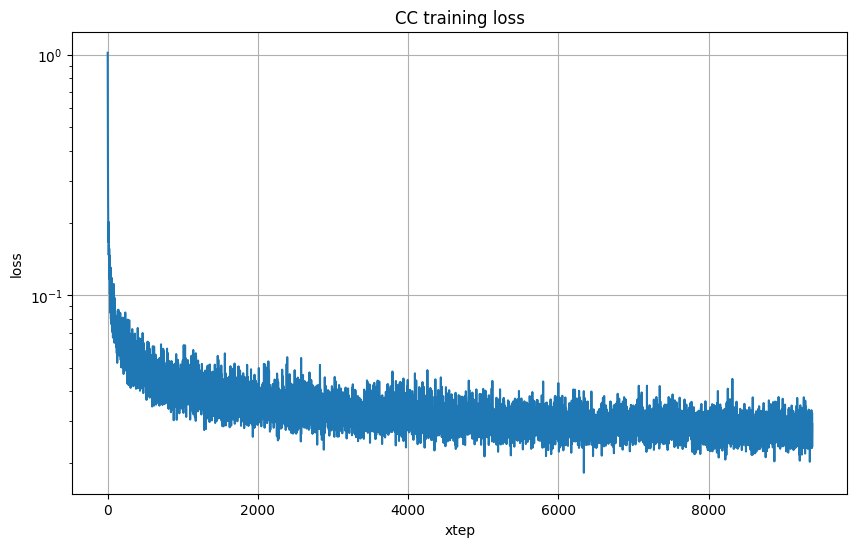

In [ ]:
# @title Deliverable 2-3
# A training loss curve plot for the class-conditioned UNet over the whole training process.
# === CODE TODO BEGIN ===
plt.figure(figsize=(10, 6))
plt.plot(all_losses)
plt.title('CC training loss')
plt.xlabel('xtep')
plt.ylabel('loss')
plt.yscale('log')
plt.grid(True)
plt.show()


# === CODE TODO END ===

In [ ]:
# @title Deliverable 2-4
# Sampling results for the class-conditioned UNet for 5 and 20 epochs.
# Generate 4 instances of each digit. Note: providing a gif is optional.
# Hint: You can either visualize results immediately during training (recommended for easier comparison),
#  or Store outputs and visualize later after training.
# === CODE TODO BEGIN ===

def display(epoch_num):
    if epoch_num not in sample_results:
        checkpoint_path=os.path.join(checkpoint_dir,f"class_model_epoch_{epoch_num}.pt")
        checkpoint=torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])

        digit_samples={}
        for digit in range(10):
            c=torch.full((4,), digit, dtype=torch.long, device=cfg.device)
            samples=ddpm_sample(model, schedule,c,(28,28),cfg.num_ts,guidance_scale=5.0)
            digit_samples[digit]=samples.cpu()

        sample_results[epoch_num]=digit_samples

    samples_to_show=[]
    for digit in range(10):
        for i in range(4):
            sample=sample_results[epoch_num][digit][i].squeeze().cpu().numpy()
            samples_to_show.append(sample)

    print(f"sample from {epoch_num}:")
    media.show_images(samples_to_show, columns=4)

display(5)
display(20)

# === CODE TODO END ===

sample from 5:


,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,


sample from 20:


,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,
,,,


# Extra Credit

## Improve the UNet Architecture for time-conditional generation
For ease of explanation and implementation, our UNet architecture above is pretty simple. Modify the UNet (e.g. with skip connections) such that it can fit better during training and sample even better results.

## Implement Rectified Flow
- Implement [rectified flow](https://arxiv.org/abs/2209.03003), which is the state of art diffusion model.
- You can reference any code on github, but your implementation needs to follow the same code structure as our DDPM implementation.
- In other words, the code change required should be minimal: only changing the forward and sample functions.

# Generating a PDF for CMSX

You can just use `File > Print` to get a pdf of this page. Please double check that no outputs are cutoff!